In [1]:
import numpy
import matplotlib.pyplot as plt
import rasterio
import os

In [2]:
img_folder = r'F:\deforestation-detection-master\data\IMG_DATA\R10m'
bands = ['B01','B02','B03','B04','B08']

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path

def load_landsat_image(img_folder, bands):
    image = {}
    path = Path(img_folder)
    for band in bands:
        try:
            file = next(path.glob(f'*_{band}_10m.jp2'))
            print(f'Opening file {file}')
            ds = rasterio.open(file)
            image.update({band: ds.read(1)})
        except StopIteration:
            print(f'No file found for band {band}')
    
    return image

In [4]:
def normalized_difference(img, b1, b2, eps=0.0001):
    band1 = np.where((img[b1]==0) & (img[b2]==0), np.nan, img[b1])
    band2 = np.where((img[b1]==0) & (img[b2]==0), np.nan, img[b2])
    
    return (band1 - band2) / (band1 + band2 + eps)

Opening file F:\deforestation-detection-master\data\IMG_DATA\R10m\T44NMP_20190327T045659_B02_10m.jp2
Opening file F:\deforestation-detection-master\data\IMG_DATA\R10m\T44NMP_20190327T045659_B03_10m.jp2
Opening file F:\deforestation-detection-master\data\IMG_DATA\R10m\T44NMP_20190327T045659_B04_10m.jp2


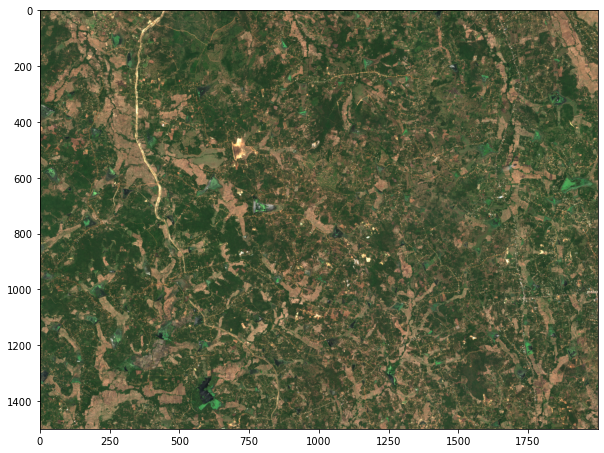

In [5]:
img2 = load_landsat_image(img_folder, ['B02','B03','B04'])

rgb = np.stack([img2['B04'], img2['B03'], img2['B02']], axis=-1)

rgb = rgb/rgb.max()*2

brightness_factor = 4.5  # Adjust this value as needed
brightened_rgb = rgb * brightness_factor

# Clip pixel values to ensure they are within the valid range [0, 1]
brightened_rgb = np.clip(brightened_rgb, 0, 1)
plt.figure(figsize=(10, 10))
# Display the brightened RGB image
plt.imshow(brightened_rgb[2500:4000, 0:2000])
plt.show()


Opening file F:\deforestation-detection-master\data\S2A_MSIL1C_20170322T045651_N0204_R119_T44NMP_20170322T051021.SAFE\GRANULE\L1C_T44NMP_A009125_20170322T051021\IMG_DATA\T44NMP_20170322T045651_B04.jp2
Opening file F:\deforestation-detection-master\data\S2A_MSIL1C_20170322T045651_N0204_R119_T44NMP_20170322T051021.SAFE\GRANULE\L1C_T44NMP_A009125_20170322T051021\IMG_DATA\T44NMP_20170322T045651_B08.jp2


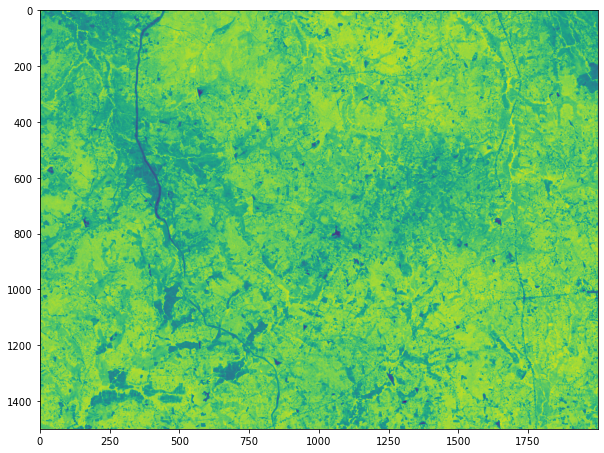

In [41]:
img = load_landsat_image(img_folder, ['B04','B08'])

ndvi = normalized_difference(img, 'B08', 'B04')

# display the image with a slightly increased figure size
plt.figure(figsize=(10,10))
plt.imshow(ndvi[2500:4000, 0:2000])


In [14]:
ndvi

'''In the context of remote sensing and vegetation analysis, 
NDVI (Normalized Difference Vegetation Index) values can become "nan" (short for "Not a Number") due to various reasons
Remote sensing data often includes pixels with no valid data, which can be represented as zeros or other placeholder values. 
When calculating NDVI, division by zero can occur if the sum of the near-infrared (NIR) and red (RED) reflectance values is zero. 
In such cases, the NDVI value becomes "nan" to indicate that the calculation is undefined due to a lack of valid data.

It's important to handle "nan" values appropriately when analyzing NDVI data. Depending on the analysis you're performing, you might choose to:

    Mask or ignore "nan" values during calculations.
    Apply data interpolation or filling techniques to estimate missing values'''    

array([[0.6609558 , 0.66281085, 0.66401363, ...,        nan,        nan,
               nan],
       [0.66041106, 0.64577815, 0.64057969, ...,        nan,        nan,
               nan],
       [0.6470588 , 0.63829785, 0.65517239, ...,        nan,        nan,
               nan],
       ...,
       [0.2016048 , 0.24676616, 0.36143409, ...,        nan,        nan,
               nan],
       [0.21070896, 0.32182253, 0.40740739, ...,        nan,        nan,
               nan],
       [0.31249999, 0.38616461, 0.41352738, ...,        nan,        nan,
               nan]])

In [15]:
deforested_mask = ndvi < 0.5
non_deforested_mask = ~deforested_mask

NameError: name 'ndvi' is not defined

C:\Users\ravin\AppData\Local\Temp\ipykernel_20748\1136861983.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlGn").copy()
  cmap.set_bad(color='black')


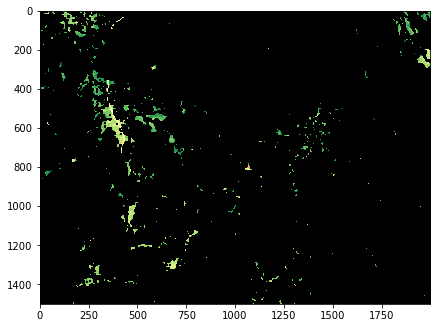

In [30]:
masked_ndvi = np.ma.masked_array(ndvi, mask= non_deforested_mask)
cmap = plt.cm.RdYlGn  # Choose a colormap (e.g., Red-Yellow-Green)
cmap.set_bad(color='black')
plt.figure(figsize=(7, 7))
plt.imshow(masked_ndvi[2500:4000, 0:2000],cmap=cmap)

In [72]:
mean_ndvi_deforested = np.mean(masked_ndvi)
mean_ndvi_deforested

0.33385961117908175

In [75]:
# Extract the date from the data folder path
date_str = img_folder.split('_')[2]
year = date_str[:4]
month = date_str[4:6]
date = date_str[6:8]

output_folder = 'F:\\deforestation-detection-master\\data\\tiff'

# Save the masked NDVI image as a GeoTIFF file using the extracted date as the filename
output_filename = f'ndvi_img_{year}_{month}_{date}.tif'  
masked_ndvi_data = masked_ndvi[2500:4000, 0:2000].data # Get the unmasked data
profile = {
    'driver': 'GTiff',
    'dtype': masked_ndvi_data.dtype,
    'height': masked_ndvi_data.shape[0],
    'width': masked_ndvi_data.shape[1],
    'count': 1,
    'transform': rasterio.transform.from_origin(0, 0, 0.01, 0.01),  # Adjust as needed
}

output_path = os.path.join(output_folder, output_file)  
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(masked_ndvi_data, 1)

plt.show()


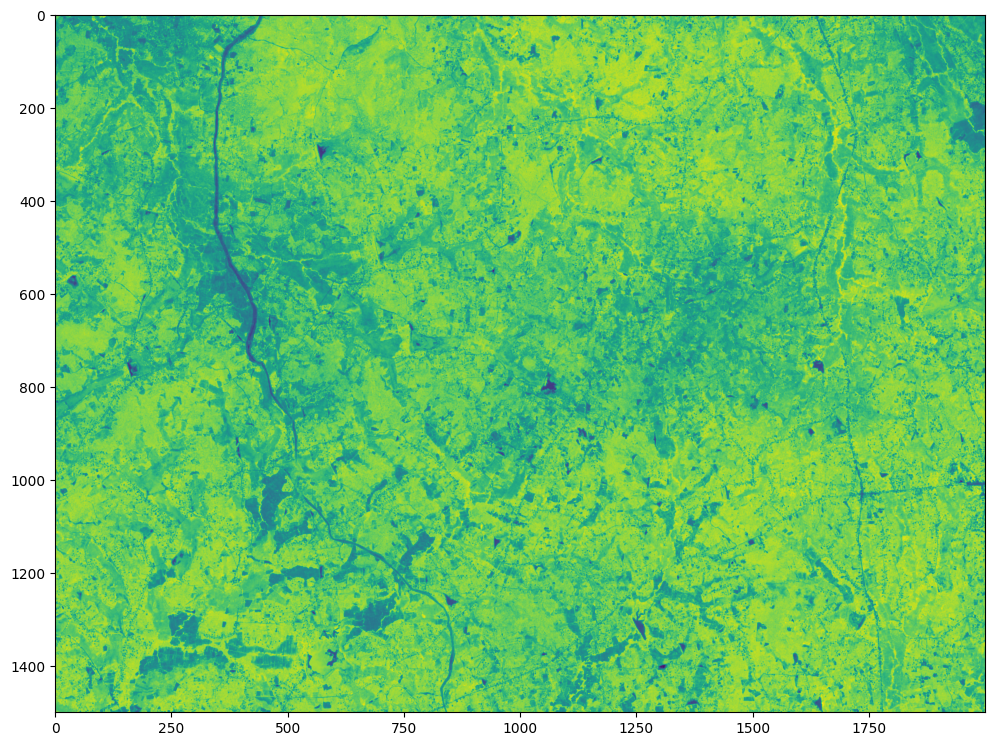

In [26]:
import rasterio
import matplotlib.pyplot as plt

# Specify the path to the TIFF file
tif_file = r'D:\Data-Science\DSC4173 Project\data\Ndvi images\ndvi_img_2017_03_22.tif'

# Open the TIFF file using rasterio
with rasterio.open(tif_file) as src:
    # Read the raster data (band 1)
    tif_data = src.read(1)

    # Display the TIFF image using matplotlib
    plt.figure(figsize=(12, 12))
    plt.imshow(tif_data)  # You can use any colormap you prefer
    plt.show()


### Pipeline From generating and exporting ndvi images

In [25]:
#Import required libraries

import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
from pathlib import Path

#Define the data folder and bands
img_folder = r'D:\Data-Science\DSC4173 Project\data\Raw images\S2B_MSIL2A_20190327T045659_N0211_R119_T44NMP_20190327T112357\S2B_MSIL2A_20190327T045659_N0211_R119_T44NMP_20190327T112357.SAFE\GRANULE\L2A_T44NMP_A010727_20190327T051528\IMG_DATA\R10m'
bands = ['B01','B02','B03','B04','B08','TCI']

#function for making data dictionary
def load_landsat_image(img_folder, bands):
    image = {}
    path = Path(img_folder)
    for band in bands:
        try:
            file = next(path.glob(f'*_{band}_10m.jp2'))
            print(f'Opening file {file}')
            ds = rasterio.open(file)
            image.update({band: ds.read(1)})
        except StopIteration:
            print(f'No file found for band {band}')
    
    return image

#Funcition for generating ndvi image
def normalized_difference(img, b1, b2, eps=0.0001):
    band1 = np.where((img[b1]==0) & (img[b2]==0), np.nan, img[b1])
    band2 = np.where((img[b1]==0) & (img[b2]==0), np.nan, img[b2])
    
    return (band1 - band2) / (band1 + band2 + eps)


def export_ndvi(output_folder_path):
    img = load_landsat_image(img_folder, ['B04','B08'])
    ndvi = normalized_difference(img, 'B08', 'B04')

    date_str = img_folder.split('_')[2]
    year = date_str[:4]
    month = date_str[4:6]
    date = date_str[6:8]

    output_folder = output_folder_path

    # Save the masked NDVI image as a GeoTIFF file using the extracted date as the filename
    output_filename = f'ndvi_img_{year}_{month}_{date}.tif'  

    ndvi_data = ndvi[2500:4000, 0:2000] # Get the specific area of study


    profile = {
        'driver': 'GTiff',
        'dtype': ndvi_data.dtype,
        'height': ndvi_data.shape[0],
        'width': ndvi_data.shape[1],
        'count': 1,
        #'crs': 'EPSG:32644',
        'transform': rasterio.transform.from_origin(0, 0, 0.01, 0.01),

    }

    output_path = os.path.join(output_folder, output_filename)  
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(ndvi_data, 1)

if __name__ == "__main__":
    export_ndvi(r'D:\Data-Science\DSC4173 Project\data\Ndvi images')


Opening file D:\Data-Science\DSC4173 Project\data\Raw images\S2B_MSIL2A_20190327T045659_N0211_R119_T44NMP_20190327T112357\S2B_MSIL2A_20190327T045659_N0211_R119_T44NMP_20190327T112357.SAFE\GRANULE\L2A_T44NMP_A010727_20190327T051528\IMG_DATA\R10m\T44NMP_20190327T045659_B04_10m.jp2
Opening file D:\Data-Science\DSC4173 Project\data\Raw images\S2B_MSIL2A_20190327T045659_N0211_R119_T44NMP_20190327T112357\S2B_MSIL2A_20190327T045659_N0211_R119_T44NMP_20190327T112357.SAFE\GRANULE\L2A_T44NMP_A010727_20190327T051528\IMG_DATA\R10m\T44NMP_20190327T045659_B08_10m.jp2
